Importing Dependencies  

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from   sklearn.metrics import confusion_matrix
from   sklearn.model_selection import train_test_split, cross_validate
from   PIL import Image

In [2]:
#Device Configuration
#device = torch.device('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_num = torch.cuda.device_count()
device_name = torch.cuda.get_device_name()

print(device)
print(device_num)
print(device_name)

cuda
1
NVIDIA GeForce RTX 3070


In [3]:
#Hyper Parameters
num_classes = 2
num_epochs = 3
batch_size = 100
learning_rate = 0.001

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
#Importing and Convert Images to Tensor
datadir = 'CIVL498A\Data'
categories = ['Positive','Negative'] #0 positive and cracked, 1 is negative and no-crack
label_list = ['Crack', 'No Crack']

conc_data = [] #conc_data[tensor][label]

def create_conc_data():
    for category in categories:
        path = os.path.join(os.getcwd(), category)
        class_num = categories.index(category)

        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            img_open = Image.open(img_path)
            image = transform(img_open)

            conc_data.append([image, class_num])
create_conc_data()

In [11]:
os.getcwd()

'c:\\Users\\Dave\\Desktop\\Data'

In [6]:
print(len(conc_data))

40000


In [13]:
print(conc_data[39999])

[tensor([[[ 0.3804,  0.4039,  0.4275,  ...,  0.3020,  0.3020,  0.3020],
         [ 0.3804,  0.4039,  0.4196,  ...,  0.2863,  0.2863,  0.2941],
         [ 0.3804,  0.3961,  0.4039,  ...,  0.3020,  0.3020,  0.3020],
         ...,
         [ 0.1373,  0.1294,  0.1373,  ..., -0.0039,  0.0118,  0.0275],
         [ 0.1451,  0.1373,  0.1373,  ..., -0.0196, -0.0039,  0.0118],
         [ 0.1608,  0.1529,  0.1451,  ..., -0.0353, -0.0196, -0.0039]],

        [[ 0.3098,  0.3333,  0.3569,  ...,  0.2314,  0.2314,  0.2314],
         [ 0.3098,  0.3333,  0.3490,  ...,  0.2157,  0.2157,  0.2235],
         [ 0.3098,  0.3255,  0.3333,  ...,  0.2314,  0.2314,  0.2314],
         ...,
         [ 0.1216,  0.1137,  0.1216,  ..., -0.0275, -0.0118,  0.0039],
         [ 0.1294,  0.1216,  0.1216,  ..., -0.0431, -0.0275, -0.0118],
         [ 0.1451,  0.1373,  0.1294,  ..., -0.0588, -0.0431, -0.0275]],

        [[ 0.2392,  0.2627,  0.2863,  ...,  0.1608,  0.1608,  0.1608],
         [ 0.2392,  0.2627,  0.2784,  ...,  

In [8]:
#using a 80% train and 20% test split with random state of 42
train_dataset, test_dataset = train_test_split(conc_data, test_size=0.2, random_state=42)

In [9]:
print(len(train_dataset))

32000


In [10]:
print(len(test_dataset))

8000


In [15]:
#Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

In [16]:
#Define function to show image.
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize = (24,8))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

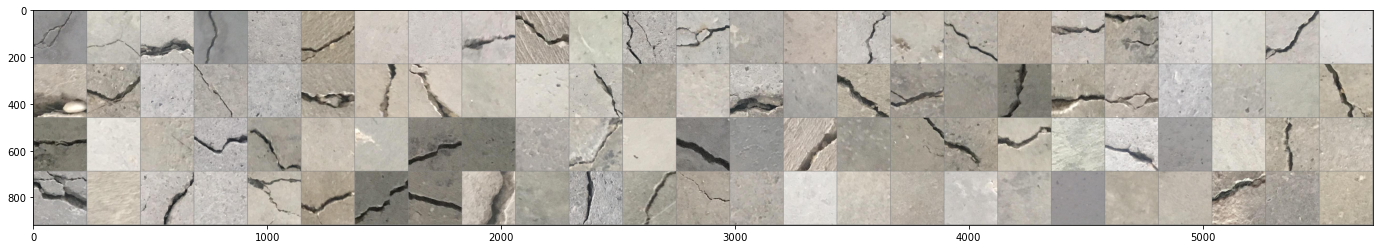

In [19]:
#Show some random images
sample = iter(train_loader)
sample_image, sample_label = sample.next()

grid_img = torchvision.utils.make_grid(sample_image, nrow=25)
imshow(grid_img)

In [14]:
sample_image.shape #batch size of 10, with 3 channels, 227 by 227 images

torch.Size([100, 3, 227, 227])

In [20]:
sample_label.shape #batch size of 10 labels

torch.Size([100])

In [104]:
#new CNN module
class concreteCNN(nn.Module):
    def __init__(self):
        super(concreteCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,8,5, stride=1, padding=0)
        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8,32,5, stride=1, padding=0)
        
        self.fc1 = nn.Linear(32*53*53, 256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*53*53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [105]:
#Loss and Optimizer
cnn_model = concreteCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [106]:
#Train the model
n_total_steps = len(train_loader)
epoch_loss = []
step_loss = []

for epoch in range(num_epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        labels = labels.to(device)
        images = images.to(device)

        #forward
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        #backwards
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print the losses
        #print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss = {loss.item():.4f}')

        running_loss += loss.item()
        step_loss.append(loss.item())

    average_loss = running_loss/len(train_loader)
    print(f'Average loss for Epoch {epoch+1}  is {average_loss:.4f}.')
    epoch_loss.append(average_loss)


Average loss for Epoch 1  is 0.0753.
Average loss for Epoch 2  is 0.0200.
Average loss for Epoch 3  is 0.0133.


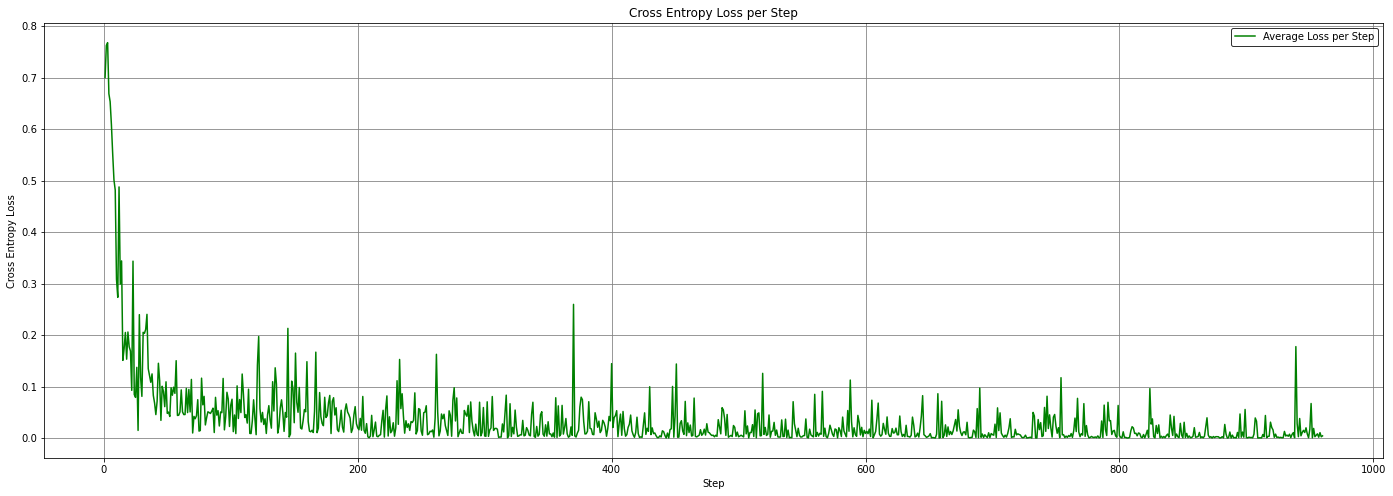

In [107]:
#Plot of loss per step of the model training
fig,ax = plt.subplots(1,1, figsize = (24,8))
x_value = np.linspace(1,n_total_steps*num_epochs,n_total_steps*num_epochs)
y_value = step_loss
ax.plot(x_value, y_value, color='g', label='Average Loss per Step')

ax.set_title('Cross Entropy Loss per Step')
ax.set_xlabel('Step')
ax.set_ylabel('Cross Entropy Loss')
ax.legend(loc='upper right', edgecolor='black')
ax.grid(color='grey')

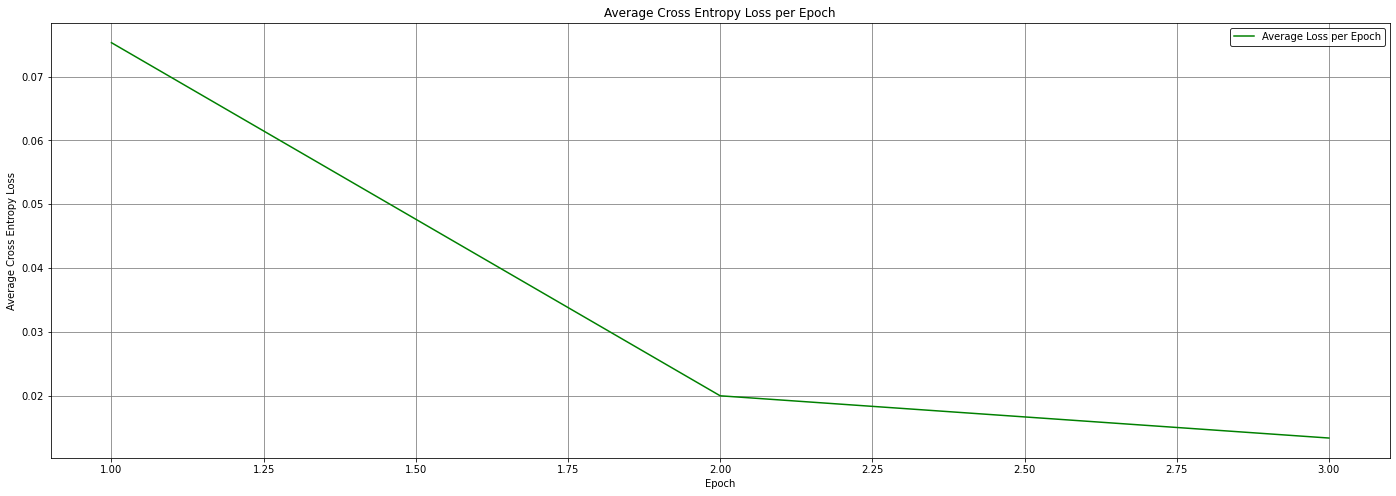

In [108]:
#Plot of loss per epoch of the model training
fig,ax = plt.subplots(1,1, figsize = (24,8))
x_value = np.linspace(1,num_epochs,num_epochs)
y_value = epoch_loss
ax.plot(x_value, y_value, color='g', label='Average Loss per Epoch')

ax.set_title('Average Cross Entropy Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Cross Entropy Loss')
ax.legend(loc='upper right', edgecolor='black')
ax.grid(color='grey')

In [109]:
#Testing the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0

    label_cm = []
    predicted_cm = []

    #n_class_correct = [0 for i in range(num_classes)]
    #n_class_samples = [0 for i in range(num_classes)]
     
    n_class_correct = [0 for i in categories]
    n_class_samples = [0 for i in categories]

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
  
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
            label_cm.append(label.item())
            predicted_cm.append(pred.item())

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc :.2f} %')

    for i in range(num_classes):
        if n_class_samples[i] == 0:
            print(f'Accuracy of {[categories] :.2f}: %')
        else:
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {[categories[i]]}: {acc :.2f} %')


Accuracy of the network: 99.64 %
Accuracy of ['Positive']: 99.55 %
Accuracy of ['Negative']: 99.72 %


In [110]:
cm = confusion_matrix(label_cm, predicted_cm)

In [111]:
print(cm)

[[3996   18]
 [  11 3975]]


In [112]:
TP = cm[0][0]
FP = cm[1][0]

In [113]:
Precision = TP/(TP+FP)
print(f'Precision Score: {Precision :.3f}')

Precision Score: 0.997


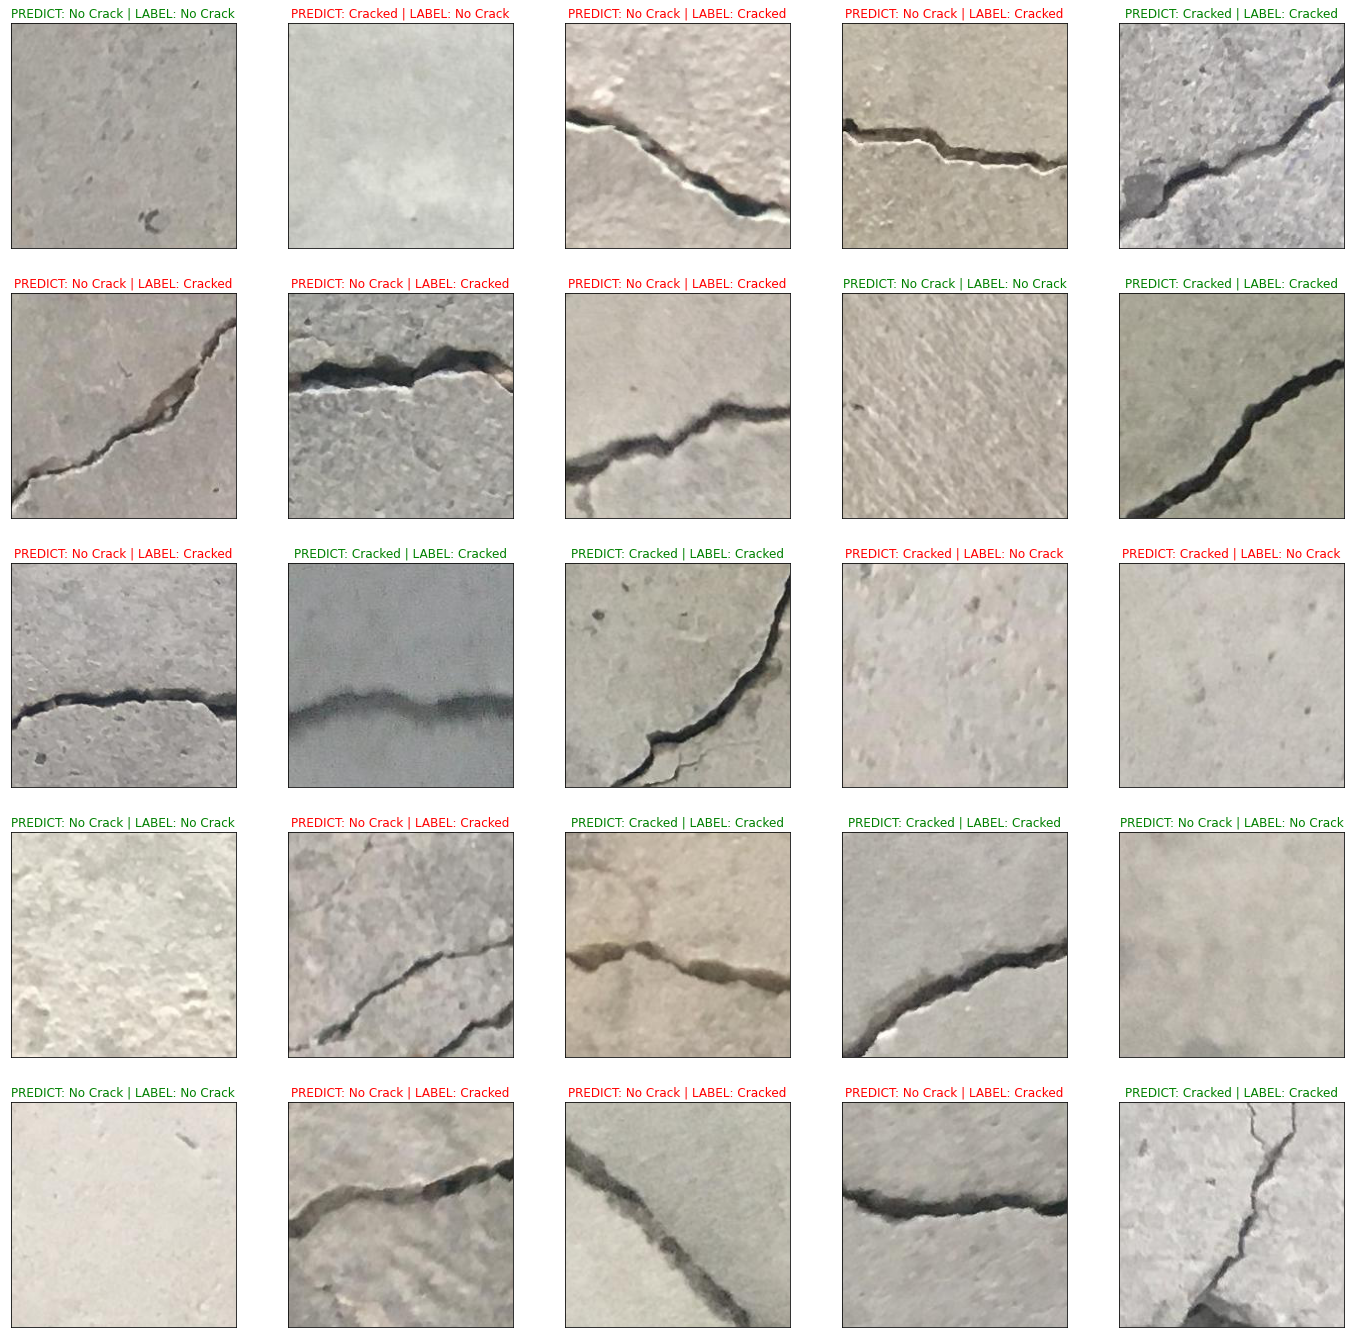

In [119]:
#Obtain one batch of test images:
test_loader_plot  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=25, shuffle=True)

dataiter = iter(test_loader_plot)
test_images, test_labels = dataiter.next() 

output = cnn_model(test_images.to(device))
_, predicted = torch.max(outputs.data, 1)

test_images = test_images.numpy()/2 + 0.5

fig = plt.figure(figsize = (24,24))
for index in range(25):
    ax = fig.add_subplot(5,5, index+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(test_images[index],(1,2,0)))

    if predicted[index].item() == 1:
        pred = 'No Crack'
    else:
        pred = 'Cracked'

    if test_labels[index].item() == 1:
        label = 'No Crack'
    else:
        label = 'Cracked'

    ax.set_title('PREDICT: {} | LABEL: {}'.format(pred, label), color=("green" if predicted[index]==test_labels[index] else "red"))